**Heat equation**

Retyped by Theodoret Putra Agatho on 4 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/heat.html)

In [4]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.8 MB/s eta 0:00:00


**Problem setup**

We will solve a heat equation:

\begin{align}
        \frac{\delta u}{\delta t} = \alpha \frac{\delta ^2 u}{\delta x^2}, x \in [-1,1], t \in [0,1]
    \end{align}

where $\alpha = 0.4$ is the thermal diffusivity constant.

With Dirichlet boundary conditions:

\begin{align}
        u(0,t) = u(1,t) = 0,
    \end{align}

and periodic(sinusoidal) initial condition:

\begin{align}
        u(x,0) = sin(\frac{n \pi x}{L}), 0 < x < L, n = 1, 2, .....
    \end{align}

Where $L = 1$ is the length of the bar, $n = 1$ is the frequency of the sinusoidal initial conditions.

The exact solution is $u(x,t) = e^{\frac{-n^2 \pi ^2 \alpha t}{L^2}} sin(\frac{n \pi x}{L})$.

**Implementation**
This description goes through the implementation of a solver for the above described Heat equation step-by-step.

First, the DeepXDE are imported:

In [10]:
import deepxde as dde
import numpy as np

We begin by defining the parameters of the equation:

In [7]:
a = 0.4
L = 1
n = 1

Next, we define a computational geometry and time domain. We can use a built-in class `Interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` as follows

In [8]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the Heat equation:

In [9]:
def pde(x, y):
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  return dy_t - a * dy_xx

The first argument to `pde` is 2-dimensional vector where the first component(`x[:,0`) is $x$-coordinate and the second componenet(`x[:,1`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $u(x, t)$, but here we use `y` as the name of the variable.

Next, we consider the boundary/initial condition. `on_boundary` is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. We include the `geomtime` space, time geometry created above and `on_boundary` as the BCs in the `DirichletBC` function of DeepXDE. We also define `IC` which is the initial condition for the burgers equation and we use the computational domain, initial function, and `on_initial` to specify the IC.

In [11]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

Now, we have specified the geometry, PDE residual, and boundary/initial condition. We then define the `TimePDE` problem as

In [12]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)

The number 2540 is the number of training residual points sampled inside the domain, and the number 80 is the number of training points sampled on the boundary. We also include 160 initial residual points for the initial conditons.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:

In [13]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [14]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.087067 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.703351 s



We then train the model for 20000 iterations:

In [15]:
losshistory, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.13e-01, 4.79e-02, 4.07e-01]    [1.12e-01, 4.79e-02, 4.07e-01]    []  
1000      [2.11e-03, 4.90e-04, 5.57e-04]    [1.43e-03, 4.90e-04, 5.57e-04]    []  
2000      [4.05e-04, 6.05e-05, 6.08e-05]    [2.55e-04, 6.05e-05, 6.08e-05]    []  
3000      [3.87e-04, 1.70e-04, 5.39e-05]    [2.97e-04, 1.70e-04, 5.39e-05]    []  
4000      [9.51e-05, 1.55e-05, 7.84e-06]    [5.21e-05, 1.55e-05, 7.84e-06]    []  
5000      [6.55e-05, 8.37e-06, 3.39e-06]    [3.44e-05, 8.37e-06, 3.39e-06]    []  
6000      [4.89e-05, 5.23e-06, 1.51e-06]    [2.50e-05, 5.23e-06, 1.51e-06]    []  
7000      [1.79e-04, 3.35e-05, 1.64e-04]    [1.36e-04, 3.35e-05, 1.64e-04]    []  
8000      [3.20e-05, 3.25e-06, 4.56e-07]    [1.63e-05, 3.25e-06, 4.56e-07]    []  
9000      [2.73e-05, 3.12e-06, 7.75e-07]    [1.45e-05, 3.12e-06, 7.75e-07]    []  
10000     [2.33e-05, 2.55e-06, 2.49e-07]    [1.22e-05, 2.55e-

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [17]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.359110 s

Training model...

Step      Train loss                        Test loss                         Test metric
20000     [1.01e-05, 1.45e-06, 1.48e-06]    [6.88e-06, 1.45e-06, 1.48e-06]    []  
20324     [1.33e-06, 6.60e-08, 8.76e-09]    [1.09e-06, 6.60e-08, 8.76e-09]    []  

Best model at step 20324:
  train loss: 1.41e-06
  test loss: 1.16e-06
  test metric: []

'train' took 6.602096 s



**Additional Visualisation**

Additional code to give visualisation of the results. Taken parts are from **Complete code** section.

In [20]:
def heat_eq_exact_solution(x, t):
  """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

  Parameters
  ----------
  x : np.ndarray
  t : np.ndarray
  """
  return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

def gen_exact_solution():
  """Generates exact solution for the heat equation for the given values of x and t."""
  # Number of points in each dimension:
  x_dim, t_dim = (256, 201)

  # Bounds of 'x' and 't'
  x_min, t_min = (0, 0.0)
  x_max, t_max = (L, 1.0)

  # Create tensors:
  t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
  x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
  usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

  # Obtain the value of the exact solution for each generated point:
  for i in range(x_dim):
    for j in range(t_dim):
      usol[i][j] = heat_eq_exact_solution(x[i], t[j])

  # Save solution:
  np.savez("heat_eq_data", x=x, t=t, usol=usol)

def gen_testdata():
  """Import and preprocess the dataset with the exact solution."""
  # Load the data:
  data = np.load("heat_eq_data.npz")
  # Obtain the values for t, x, and the exact solution:
  t, x, exact = data["t"], data["x"], data["usol"].T
  # Process the data and flatten it out (Like labels and features):
  xx, tt = np.meshgrid(x, t)
  X = np.vstack((np.ravel(xx), np.ravel(tt))).T
  y = exact.flatten()[:, None]
  return X, y

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


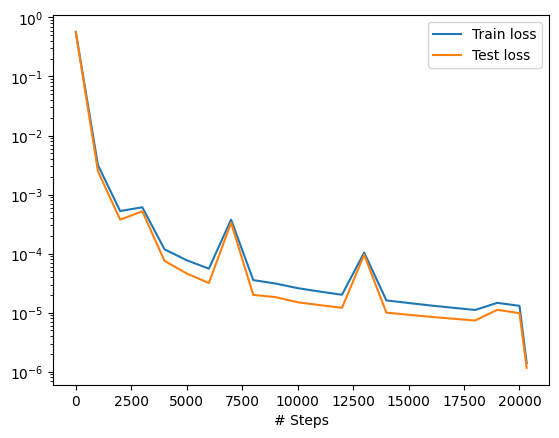

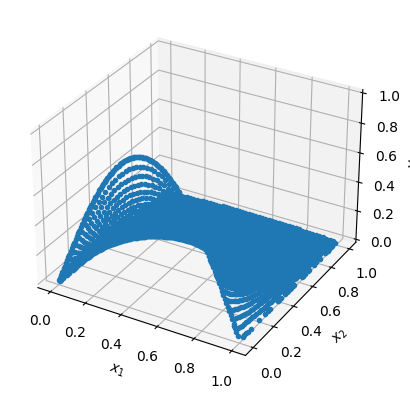

Mean residual: 0.00082327786
L2 relative error: 0.000567376193593865


In [22]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
gen_exact_solution()
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))